In [1]:
import mbuild as mb
from mbuild.formats.hoomd_simulation import create_hoomd_simulation
import hoomd
import hoomd.md
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Use Hoomd to build a simple LJ-particle system:

def build_system(packing='bcc'):
    '''
    Generate a simple LJ particle system using hoomd's create_lattice function
    packing 
    '''
    hoomd.context.initialize("")
    if packing == 'fcc':
        system = hoomd.init.create_lattice(unitcell=(hoomd.lattice.fcc(a=1.58)), n=6)
    elif packing == 'bcc':
        system = hoomd.init.create_lattice(unitcell=(hoomd.lattice.bcc(a=1.29)), n=6)
    hoomd.dump.gsd('{}_system.gsd'.format(packing), group = hoomd.group.all(), period=None, overwrite=True)
    return system

def hoomd_simulation(system, temp, tau):  
    nl = hoomd.md.nlist.cell()
    lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
    lj.pair_coeff.set('A', 'A', alpha=1.0, epsilon=1.0, sigma=1.0)
    hoomd.md.integrate.mode_standard(dt=0.001)
    _all = hoomd.group.all()
    nvt = hoomd.md.integrate.nvt(group=_all, kT=temp, tau=tau)
    nvt.randomize_velocities(seed=23)
    hoomd.analyze.log(filename='{}-tau_out.log'.format(tau),
                      quantities=["time", "temperature", "potential_energy"],
                      period=100,
                      overwrite=True
                     )
    #hoomd.dump.gsd('tau-trajectory.gsd', period=5e3, group=_all, overwrite=True)
    hoomd.run(3e5)

In [3]:
bcc = build_system()

HOOMD-blue v2.9.0-16-g08515af02 CUDA (10.1) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX AVX2 
Compiled: 05/12/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Lui, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the following GPU(s):
 [0]      GeForce RTX 2070  36 SM_7.5 @ 1.44 GHz, 7982 MiB DRAM, DIS, MNG
notice(2): Group "all" created containing 432 particles


In [4]:
temp = 1.0
tau = 0.1
hoomd_simulation(bcc, temp, tau)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 432
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 124248 / 300000 | TPS 12424.8 | ETA 00:00:14
Time 00:00:20 | Step 256167 / 300000 | TPS 13191.8 | ETA 00:00:03
Time 00:00:23 | Step 300000 / 300000 | TPS 13208.6 | ETA 00:00:00
Average TPS: 12865
---------
-- Neighborlist stats:
5035 normal updates / 1000 forced updates / 0 dangerous updates
n_neigh_min: 83 / n_neigh_max: 102 / n_neigh_avg: 93.7222
shortest rebuild period: 35
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 47 / n_max: 61 / n_avg: 54
** run complete **


In [5]:
data = np.genfromtxt('{}-tau_out.log'.format(tau), names=True, delimiter="\t")

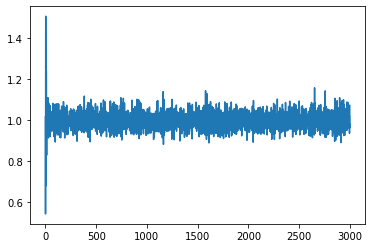

In [6]:
plt.plot(data['temperature'])